Lung Cancer Detection using Convolutional Neural Network (CNN)

Importing Necessary Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob


from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras  import layers

import warnings
warnings.filterwarnings('ignore')

Extracting the Dataset

In [2]:
from zipfile import ZipFile
data_path='D:/Downloads/archive (2).zip'
with ZipFile(data_path,'r') as zip:
    zip.extractall()
    print('Data Extracted')

Data Extracted


Exploring the Dataset

In [4]:
path='lung_colon_image_set/lung_image_sets'
classes=os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

Displaying Sample Images

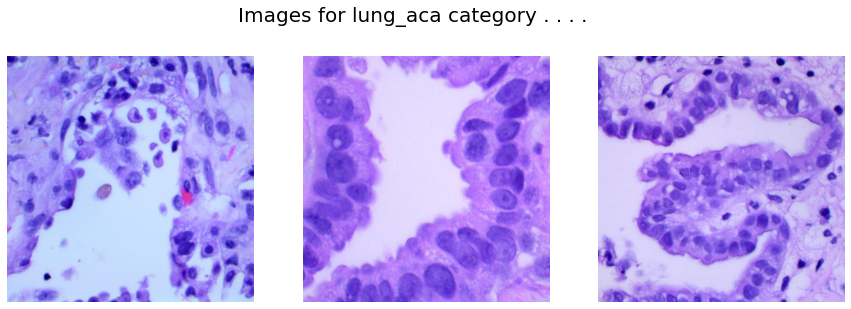

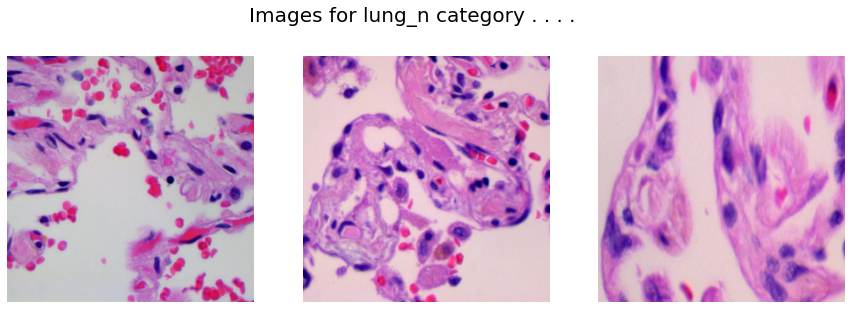

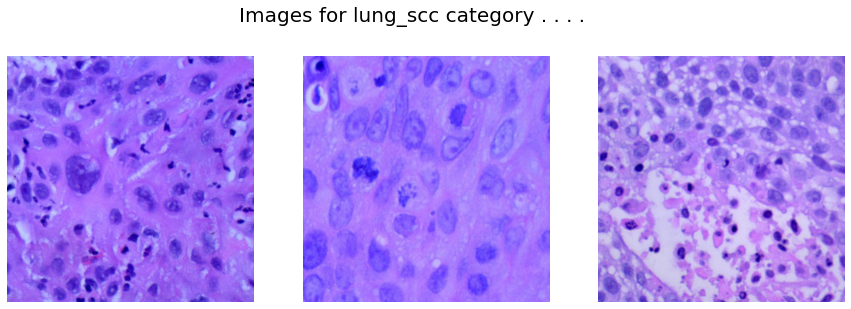

In [7]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


Setting Hyperparameters

In [10]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64
# IMG_S = 256: Sets the size to which all images will be resized. Images will be 256 pixels in height and width.

# SPLIT = 0.2: Specifies the proportion of the dataset to be used as the validation set (20% in this case).

# EPOCHS = 10: Sets the number of times the entire dataset will be passed through the neural network during training.

# BATCH_SIZE = 64: Sets the number of samples that will be propagated through the network at once. Using batches helps in efficient computation.

Preparing the Data

In [11]:
X=[]
Y=[]
for i,cat in enumerate(classes):
    images=glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img=cv2.imread(image)
        X.append(cv2.resize(img,(IMG_SIZE, IMG_SIZE)))
        Y.append(i)
        
X=np.asarray(X)
one_hot_encoded_Y=pd.get_dummies(Y).values

Splitting the Data

In [14]:
X_train,X_test,Y_train,Y_test=train_test_split(X,one_hot_encoded_Y,test_size=SPLIT,random_state=2022)
print(X_train.shape,X_test.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


Building the CNN Model

In [16]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


Compiling the Model

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Setting Up Callbacks

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached up to 90% so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)


Training the Model

In [20]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 [==============================] - 782s 4s/step - loss: 0.3664 - accuracy: 0.8447 - val_loss: 20.0490 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 743s 4s/step - loss: 0.2177 - accuracy: 0.9135 - val_loss: 4.9300 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 744s 4s/step - loss: 0.1671 - accuracy: 0.9328 - val_loss: 2.9198 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 757s 4s/step - loss: 0.1380 - accuracy: 0.9465 - val_loss: 20.5194 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 803s 4s/step - loss: 0.1113 - accuracy: 0.9578 - val_loss: 0.7644 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 840s 4s/step - loss: 0.0907 - accuracy: 0.9643 - val_loss: 1.7679 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - ETA: 0s 

Visualizing Training Progress

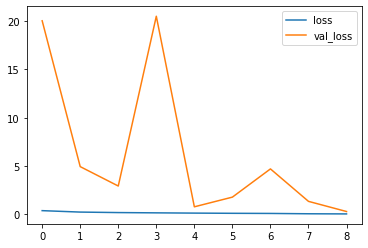

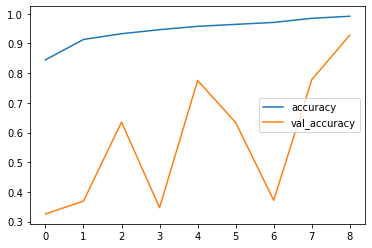

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Evaluating the Model

In [23]:
Y_pred = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 28s 282ms/step


Generating Confusion Matrix and Classification Report

In [24]:
metrics.confusion_matrix(Y_test, Y_pred)


array([[851,   4, 132],
       [ 32, 945,   0],
       [ 48,   0, 988]], dtype=int64)

In [25]:
print(metrics.classification_report(Y_test, Y_pred,
                                    target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.91      0.86      0.89       987
      lung_n       1.00      0.97      0.98       977
    lung_scc       0.88      0.95      0.92      1036

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

